In [2]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

### Initial data reading
#### Read the folder files with the mean of $e_{normal}$ and $e_{tumor}$
1. Store names in a list
2. Store values in a list of list to transform later into an array

In [3]:
folder_path = "./data_external/mean_exp_values/"
file_list = []
data_store = []

for file in os.listdir(folder_path):
    # store the file name withouth path and extention
    file_list.append(file.split('.')[0])
    # store the data from each file
    data_store.append(pd.read_csv(folder_path+'/'+file,
                                  sep='\t',header=None).iloc[:,0])
# numpy array
data_store = np.array(data_store)

### Preparing data

Separating tumor and normal mean values by using numpy mask to evaluate in array and listing tissues and genes

In [4]:
# Creating masks
normal_mask = [name[:6] == 'normal' for name in file_list]
tumor_mask = [name[:5] == 'tumor' for name in file_list]

# List of different tissues
tissues = np.unique(
    [''.join(re.findall('[A-Z]', string)) for string in file_list]
    )
# Ensemble IDs
ensbl = pd.read_csv("data_external/ensemble.txt",sep='\t',header=None).iloc[:,0]

Precalculus matrix of differential expression:
$$ Log2 FC = Log2 (e/e_{ref})$$
df $->$ DataFrame with features as columns: ensemble IDs and samples as index: tissues

In [5]:
# Calculate log2 fold-change of gene exprssion with normal tissue as reference
Log2FC = np.log2(data_store[tumor_mask]/data_store[normal_mask])

# DataFrame of gene expression fold-change
df = pd.DataFrame(data=Log2FC,columns=ensbl,index=tissues)

### Pathways
#### Top 28 pathways from Reactome
Read the pathway data and store pathway names and genes in pathways

In [6]:
# Read the Top 28 pathways excel list
top_pathways = pd.read_excel("data_pathways/pathways2_sorted.xls",header=None)
# Name the columns
top_pathways.columns = ["Ensemble","Pathways"]

# Count pathways
pathways_names = pd.unique(top_pathways.Pathways)
# Count genes in pathways
genes_annotated = pd.unique(top_pathways.Ensemble)

# Print ranges
print(" Top Pathways:",
      pathways_names.shape[0],"\n",
      "Annotated Genes:",
      genes_annotated.shape[0]
      )

 Top Pathways: 28 
 Annotated Genes: 10785


Get matching genes in pathways and evaluate in top-pathways dataframe

In [7]:
# Genes in pathways
genes_path = set(ensbl) & set(genes_annotated)

# Pathways with annotated genes
pathways_annotated = top_pathways.query('Ensemble in @genes_path')

In [8]:
X = []
for pathway in pathways_names:
    # genes evaluated in pathway (variable to operate)
    g_pathways = df[
        pathways_annotated[pathways_annotated.Pathways == pathway].Ensemble
    ]
    # Ecuation above
    X.append(np.sum(abs(g_pathways),axis=1)/g_pathways.shape[1])

X = pd.DataFrame(data=X, columns=tissues,index=pathways_names)

# Store the average pathway data
X.to_csv("./data_generated/pathways_matrix.csv")

### Principal Components Analysis

In [9]:
pca = PCA(6)
# Tissues as samples and pathways as features
P_matrix = pca.fit_transform(X.T)

print(P_matrix.shape)

(15, 6)


Saving eigenvalues and eigenvectors of the PCA

In [10]:
# Eigenvalues
np.savetxt(fname='./data_generated/pca_eigenvalues.txt', X=pca.explained_variance_)
# Eigenvectors
np.savetxt(fname='./data_generated/pca_eigenvectors',X=pca.components_)
# Variance
variance = pca.explained_variance_ratio_
np.savetxt(fname='./data_generated/variance.txt', X=variance)

Histogram of components

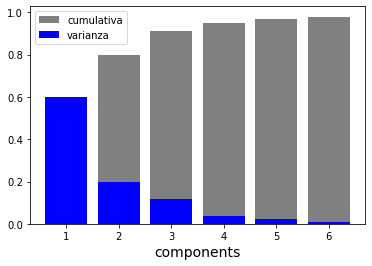

In [11]:
label = [r'cumulativa',r'varianza']

plt.bar(np.arange(1,7), variance.cumsum(), color='grey')
plt.bar(np.arange(1,7), variance, color='blue')
plt.xlabel('components', size=14)

plt.legend(label)
plt.savefig("./figures_tables/hist_process",dpi=500,bbox_inches='tight')

Table of components

In [17]:
proyections_table = pd.DataFrame(P_matrix, columns=[f'PC{i}' for i in range(1, 7)])
# Set the index as the tissues type
proyections_table.index = tissues
# Store the table into a csv file
proyections_table.to_csv('./data_generated/PCAproyections.csv')
# Visualization
proyections_table.head(14)

,PC1,PC2,PC3,PC4,PC5,PC6
BLCA,-0.202675,-0.546710,-0.151637,-0.072107,0.165033,0.040712
BRCA,0.046674,-0.326047,-0.223985,-0.031019,0.025228,-0.060265
COAD,-0.103250,0.668307,0.247695,-0.047272,0.099441,0.036723
ESCA,-0.691598,0.011853,0.481482,-0.327928,-0.096506,-0.124155
HNSC,0.210179,-0.329996,-0.087821,-0.135130,-0.135879,0.197480
KIRC,0.261946,0.440635,-0.312043,0.174902,-0.138116,-0.104818
KIRP,0.370038,0.488844,-0.328977,0.123258,-0.073498,-0.075817
LIHC,-0.572005,-0.325456,0.624810,0.501373,0.009841,0.033127
LUAD,-0.051430,-0.156975,-0.005542,0.017544,-0.027104,-0.046732
LUSC,-1.326394,-0.010234,-0.256554,-0.001946,-0.184439,-0.001064


Scatterplot of the first two components

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

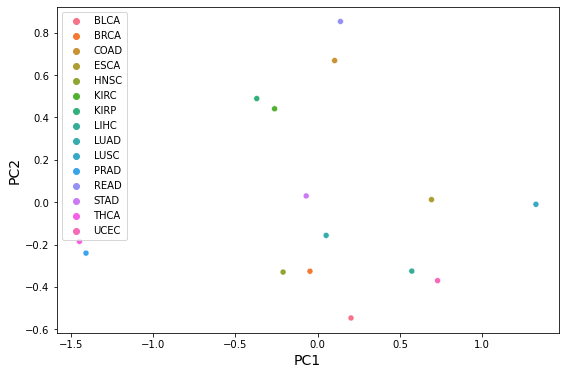

In [70]:
plt.figure(figsize = (9,6))
plt.xlabel('PC1', size=14)
plt.ylabel('PC2', size=14)

sns.scatterplot( x = -P_matrix[:,0], y = P_matrix[:,1], hue=X.columns)

Separate the group of points and create array of labels

In [81]:
# will be use as labels
hue = np.array(15*['Group1'])

# Use numpy logical indexing to set elements in 'hue' based on conditions
hue[-P_matrix[:, 0] < -1] = 'Group2'
hue[P_matrix[:, 1] > 0.3] = 'Group3'

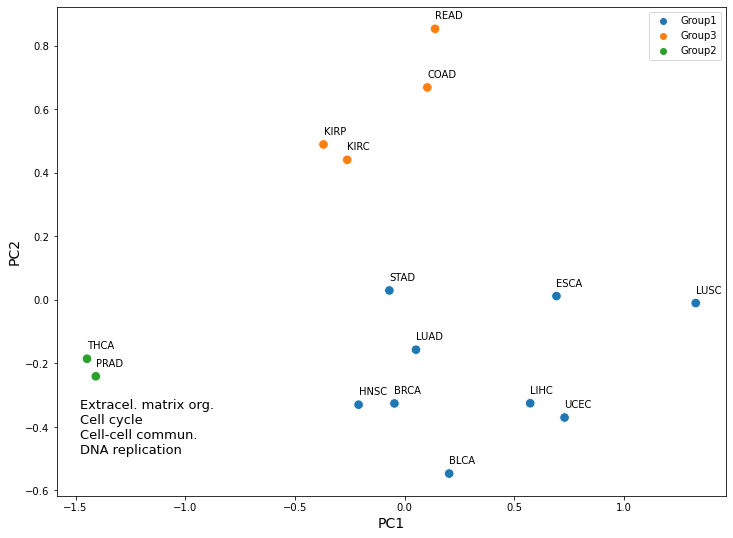

In [201]:
plt.figure(figsize = (12,9))
plt.xlabel('PC1', size=14)
plt.ylabel('PC2', size=14)

# Anotate proyections in PC1 
plt.annotate('Extracel. matrix org.',
            xy=(80, 130), xycoords='figure pixels', fontsize=13)
plt.annotate('Cell cycle',
            xy=(80, 115), xycoords='figure pixels', fontsize=13)
plt.annotate('Cell-cell commun.',
            xy=(80, 100), xycoords='figure pixels', fontsize=13)
plt.annotate('DNA replication',
            xy=(80, 85), xycoords='figure pixels', fontsize=13)

# Horizontal arrow
plt.annotate('point offset from data',
            xy=(10,-0.8), xycoords='data',
            xytext=(80,85), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.55),
            horizontalalignment='center', verticalalignment='center')


sns.scatterplot( x = -P_matrix[:,0], y = P_matrix[:,1], hue=hue, s=90)

# Add the labels to the points
for i in range(len(tissues)):
    plt.annotate(tissues[i], (-P_matrix[:,0][i], P_matrix[:,1][i]), 
                 textcoords='offset points', xytext=(0, 10))

# Store the fig
plt.savefig("./figures_tables/PCA_scatterplot",dpi=500,bbox_inches='tight')
# Show the plot
plt.show()

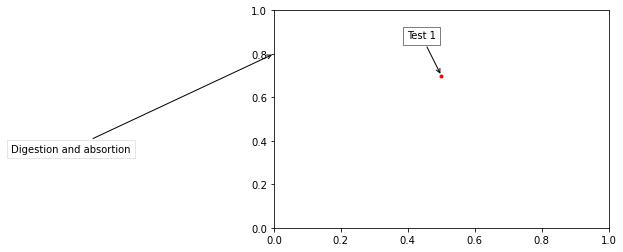

In [162]:
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data


fig, ax = plt.subplots()

# Define a 1st position to annotate (display it with a marker)
xy = (0.5, 0.7)
ax.plot(xy[0], xy[1], ".r")

# Annotate the 1st position with a text box ('Test 1')
offsetbox = TextArea("Test 1")

ab = AnnotationBbox(offsetbox, xy,
                    xybox=(-20, 40),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->"),
                    bboxprops=dict(alpha=0.5))
ax.add_artist(ab)


# Define a 2nd position to annotate (don't display with a marker this time)
xy = [0, 0.8]

# Annotate the 2nd position with a circle patch
da = TextArea("Digestion and absortion")

ab = AnnotationBbox(da, xy,
                    xybox=(1., xy[1]),
                    xycoords='data',
                    boxcoords=("axes fraction", "data"),
                    box_alignment=(5,10),
                    arrowprops=dict(arrowstyle="->"),
                    bboxprops=dict(alpha=0.1))

ax.add_artist(ab)


# Fix the display limits to see everything
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.show()

[(-1.0, 5.0), (-3.0, 5.0)]

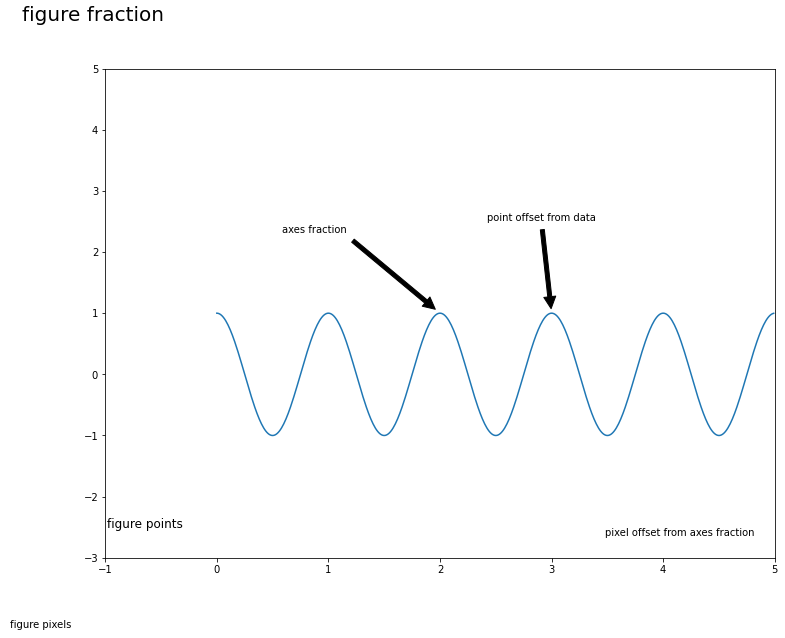

In [197]:
# Create our figure and data we'll use for plotting
fig, ax = plt.subplots(figsize=(12, 9))

t = np.arange(0.0, 5.0, 0.01)
s = np.cos(2*np.pi*t)

# Plot a line and add some simple annotations
line, = ax.plot(t, s)
ax.annotate('figure pixels',
            xy=(10, 10), xycoords='figure pixels')
ax.annotate('figure points',
            xy=(107, 110), xycoords='figure points',
            fontsize=12)
ax.annotate('figure fraction',
            xy=(.025, .975), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)

# The following examples show off how these arrows are drawn.

ax.annotate('point offset from data',
            xy=(3, 1), xycoords='data',
            xytext=(-10, 90), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='bottom')

ax.annotate('axes fraction',
            xy=(2, 1), xycoords='data',
            xytext=(0.36, 0.68), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

# You may also use negative points or pixels to specify from (right, top).
# E.g., (-10, 10) is 10 points to the left of the right side of the axes and 10
# points above the bottom

ax.annotate('pixel offset from axes fraction',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')

ax.set(xlim=(-1, 5), ylim=(-3, 5))